<a href="https://colab.research.google.com/github/cu-applied-math/appm-4600-numerics/blob/main/Demos/unused/Ch10_NewtonForIntegralEquations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np
import jax
from jax import numpy as jnp
from jax.scipy.integrate import trapezoid
from matplotlib import pyplot as plt
jax.config.update("jax_enable_x64", True)

# Solving integral equations via Newton's method

This demo was not used in class

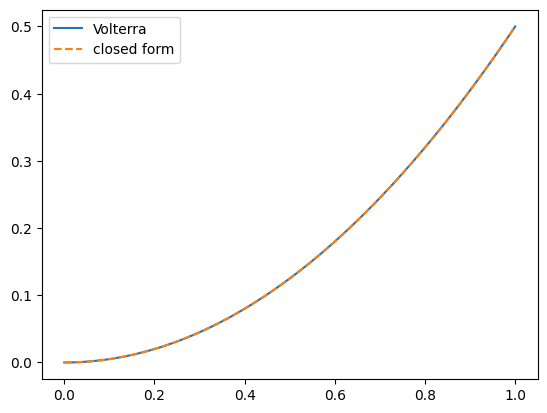

In [18]:
n = int(1e2)
xGrid = jnp.linspace(0,1,num=n)
h     = xGrid[1] - xGrid[0] # spacing
def integrate(f):
    """ numerical integration of f (implicitly over xGrid)
    using the composite trapezoidal rule """
    return h/2*(f[0] + 2*jnp.sum(f[1:-1]) + f[-1])

def integrate_Volterra(f):
    """ numerical integration of f (implicitly over xGrid)
    using the composite trapezoidal rule, returns a vector
    i.e., out[i] = int_0^{x[i]}  f(t) dt  """
    # This should be the same as:
    # scipy.integrate.cumulative_trapezoid
    # except there's no jax.scipy.integrate.cumulative_trapezoid yet

    out = jnp.cumsum(f) - 1/2*f[0] # main sum
    # Now, adjust endpoint...
    return h*( out - f/2 )

test = integrate_Volterra( jnp.linspace(0,1,n) ) # integrate \int_0^x t dt
plt.plot( xGrid, test, label='Volterra' )
plt.plot( xGrid, 1/2*xGrid**2, '--', label='closed form')
plt.legend()
plt.show()

Reached tolerance at iteration 15


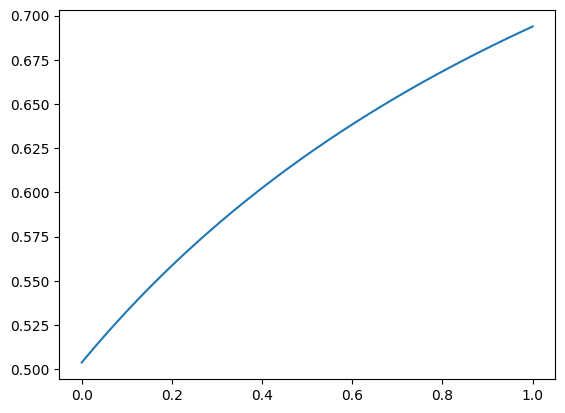

In [26]:
# https://www.colorado.edu/amath/sites/default/files/attached-files/aa_problemset_jan22.pdf, problem 2a
# Soln is straight line, a bit boring
def G(f):
    """ f represents a function, but concretely
    it is a vector of length y with the values
    of f at the grid points in xGrid """
    int_f2    = integrate( f**2 )
    int_y2f2  = integrate( xGrid**2 * f**2 )
    out = 1/3 + 1/10*( xGrid*int_f2 + int_y2f2 )
    return out

# https://www.colorado.edu/amath/sites/default/files/attached-files/gp_aa_jan2018.pdf, problem 2
lam = .8 # anything between 0 and 1
def G(f):
    """ f represents a function, but concretely
    it is a vector of length y with the values
    of f at the grid points in xGrid """
    out = jnp.empty(n)
    for i,x in enumerate(xGrid):
        # out[i] = lam*integrate(1/(1+x+f))
        out    = out.at[i].set(1-lam*integrate(1/(1+x+f)) )
    return out

# https://www.colorado.edu/amath/sites/default/files/attached-files/gp_aa_aug2017.pdf, problem 2
# def G(f):
#     """ f represents a function, but concretely
#     it is a vector of length y with the values
#     of f at the grid points in xGrid """
#     return xGrid**2 + 1/2*integrate_Volterra( jnp.sin( f**2) )

# Example 2.2 of https://www.m-hikari.com/ams/ams-2014/ams-9-12-2014/kimAMS9-12-2014-1.pdf
# y''+y=0, initial conditions y(0)=0, y'(0)=1. Soln is y(t) = sin(t)
# def G(f):



maxIts = int(100)
tol    = 1e-9
f      = .1*jnp.ones(n) # initial guess
for k in range(maxIts):
    Gf = G(f)
    if np.isfinite(Gf).all() == False:
        print(f'NaN encountered at iteration {k+1}')
        break
    if np.linalg.norm(Gf-f) < tol :
        print(f'Reached tolerance at iteration {k+1}')
        break
    f = Gf # fixed point iteration
    # plt.plot(xGrid,f,label=f'iteration {k+1}')
# plt.legend()
# plt.show()

f_fixedpt = f
plt.plot(xGrid,f)
# plt.loglog(xGrid,f) # almost linear here... i.e., u(x) = x^r
plt.show()

In [27]:
# Do Newton's method
def F(f):
    return G(f) - f

# J = jax.jacrev(G) # No! This was a mistake
J = jax.jacrev(F)

maxIts = int(10)
tol    = 1e-9
# f      = .5*jnp.ones(n) # initial guess... but a poor one! J(x) not invertible
f      = .5 + 0.2*xGrid
# f      = .5+xGrid
for k in range(maxIts):
    Jf = J(f)
    print(f'Iter {k+1}, condition number is {jnp.linalg.cond(Jf):.2e}')
    step = jnp.linalg.solve(Jf,F(f))
    # f -= step # Newton's method # Jax doesn't like this!?
    f = f.at[:].subtract( step ) # make Jax happy
    if np.isfinite(f).all() == False:
        print(f'NaN encountered at iteration {k+1}')
        break
    if np.linalg.norm(step) < tol :
        print(f'Reached tolerance at iteration {k+1}')
        break


Iter 1, condition number is 1.25e+00
Iter 2, condition number is 1.25e+00
Iter 3, condition number is 1.25e+00
Iter 4, condition number is 1.25e+00
Reached tolerance at iteration 4


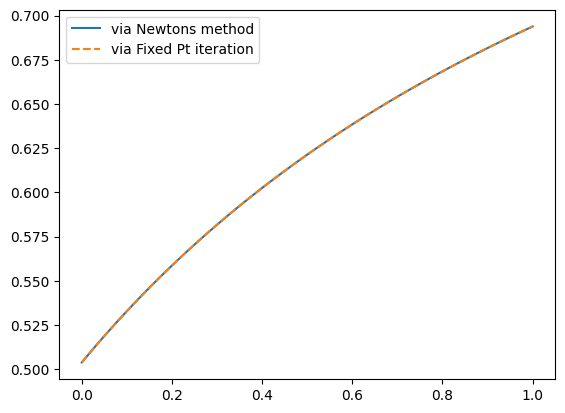

In [28]:
plt.plot(xGrid,f, label='via Newtons method')
plt.plot( xGrid, f_fixedpt, '--', label='via Fixed Pt iteration' )
plt.legend()
# plt.loglog(xGrid,f) # almost linear here... i.e., u(x) = x^r
plt.show()